In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import matplotlib.pyplot as plt
import random

from kerastuner.tuners import BayesianOptimization
from kerastuner import tuners
import kerastuner as kt
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

/home/siyoon/anaconda3/envs/siyoon/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [3]:
def plot_proba(pred,true):
    plt.figure(figsize=(8,6))
    idx=np.array(range(pred.shape[0]))
    mapped_list=list(zip(pred.squeeze(),idx))
    mapped_list.sort()
    sorted_idx=np.array(mapped_list)[:,1]
    sorted_val=np.array(mapped_list)[:,0]
    sorted_true=true[sorted_idx]
    x_val=np.array(range(pred.shape[0]))
    p1=plt.bar(x_val,sorted_val,label='Actual 0')
    p2=plt.bar(x_val[sorted_true==1],sorted_val[sorted_true==1],color='red',label='Actual 1')
    plt.xlabel('Test samples')
    plt.ylabel('Predict proba')
    plt.title('Probability of the outputs')
    plt.legend()
    #p2=ax.bar(range(len(idx_1)),pred_ts[idx_1].squeeze())
    plt.show()
    
def plot_roc_curve(pred,true):
    fpr,tpr,thresholds=roc_curve(true,pred.squeeze())
    plt.figure(figsize=(6,6))
    lw=2
    plt.plot(fpr,tpr,lw=lw,color='darkorange',label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.plot([1,0],[1,0],lw=lw,color='navy',linestyle='--')
    #plt.scatter(np.array(range(len(thresholds))),thresholds)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

def plot_pre_re_curve(pred,true):
    precision,recall,thresholds=precision_recall_curve(true,pred)
    plt.figure(figsize=(6,6))
    lw=2
    plt.plot(recall,precision,lw=lw,color='darkorange')
    #plt.plot([0,1],[1,0],lw=lw,color='navy',linestyle='--')
    #plt.scatter(np.array(range(len(thresholds))),thresholds)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall(Positive label:1)')
    plt.ylabel('Precision(Positive label:1)')
    plt.title('2-class Precision-Recall curve')
    #plt.legend(loc="lower right")
    plt.show()
    
def plot_proba_hist(pred, true):

    idx_1 = true[true==1].index.tolist()
    idx_0 = true[true==0].index.tolist()

    plt.figure(figsize=(12,10))
    plt.subplot(221)
    plt.hist(pred.loc[idx_0], bins=10, range = (0,1),label='DM=0', alpha = 0.5, edgecolor = 'white', linewidth=1.2)
    plt.xticks(np.arange(0, 1.1,0.1))
    plt.xlabel('Predict proba')
    plt.ylabel('Frequency')
    plt.title('Probability histogram (DM=0)')
    plt.legend()

    plt.subplot(222)
    plt.hist(pred.loc[idx_1], bins=10, range = (0,1), label='DM=1', alpha = 0.5, edgecolor = 'white', color = 'orange')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Predict proba')
    plt.ylabel('Frequency')
    plt.title('Probability histogram (DM=1)')
    plt.legend()
    plt.show()

def binary_converter(pred,cutoff):
    return np.where(pred>cutoff,1,0)

def bi_acc_sen_spe(pred,true):
    tn,fp,fn,tp=confusion_matrix(true,pred).ravel()
    sen=tp/(tp+fn)
    spe=tn/(tn+fp)
    acc= accuracy_score(true,pred)
    
    return acc,sen,spe

target_names = ['0','1']

In [8]:
train_raw = pd.read_csv("/nfs-data/nfs-data_1/ehkang/SW1/data/no_onehot_no_scaled_train_data_4060_27.csv")
test_raw = pd.read_csv("/nfs-data/nfs-data_1/ehkang/SW1/data/no_onehot_no_scaled_test_data_1015_27.csv")

In [9]:
train_raw

,AGE,WAIST,TOTALC,SMOKE,HBA1C,INS0,FMHTN,FMDM,GLU0,CREATININE,...,AST,ALT,WBC_B,PLAT,HB,SEX,BMI,SBP,DBP,Result
0,68.0,90.0,0.87,3.0,5.7,6.5,1.0,1.0,77.0,1.56,...,20.0,20.0,6.5,255.0,14.6,1.0,24.8292,109.0,72.0,0.0
1,70.0,109.0,1.89,1.0,5.4,10.4,1.0,1.0,91.0,0.86,...,17.0,14.0,6.0,305.0,13.8,2.0,34.5465,150.0,100.0,0.0
2,73.0,83.2,0.00,2.0,5.4,4.0,1.0,1.0,90.0,1.05,...,30.0,24.0,3.8,198.0,13.6,1.0,24.1909,131.0,83.0,0.0
3,60.0,87.1,0.00,1.0,5.2,7.8,1.0,1.0,88.0,0.85,...,25.0,25.0,3.4,185.0,11.7,2.0,24.7818,105.0,69.0,0.0
4,61.0,77.7,0.00,1.0,6.0,9.5,1.0,1.0,102.0,0.73,...,38.0,46.0,5.8,229.0,14.2,2.0,23.0517,103.0,65.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,52.0,91.1,13.66,3.0,5.3,6.9,1.0,1.0,90.0,1.21,...,17.0,16.0,5.5,215.0,16.1,1.0,25.8022,105.0,67.0,0.0
4056,57.0,82.5,2.17,1.0,5.4,9.9,1.0,1.0,84.0,0.99,...,22.0,14.0,3.6,256.0,13.8,2.0,26.9286,128.0,86.0,0.0
4057,73.0,76.5,0.00,1.0,5.2,8.5,1.0,1.0,87.0,0.80,...,23.0,16.0,4.9,270.0,12.2,2.0,21.7836,139.0,85.0,0.0
4058,53.0,78.2,0.00,1.0,5.4,5.2,1.0,1.0,90.0,0.83,...,20.0,15.0,4.1,256.0,13.5,2.0,24.2492,95.0,68.0,0.0


In [10]:
test_raw

,AGE,WAIST,TOTALC,SMOKE,HBA1C,INS0,FMHTN,FMDM,GLU0,CREATININE,...,AST,ALT,WBC_B,PLAT,HB,SEX,BMI,SBP,DBP,Result
0,55.0,95.9,19.07,2.0,5.4,6.4,1.0,1.0,89.0,1.15,...,23.0,32.0,3.3,204.0,16.1,1.0,29.7953,129.0,87.0,0.0
1,60.0,82.6,0.00,1.0,5.2,9.1,1.0,1.0,105.0,0.80,...,21.0,15.0,7.0,199.0,13.6,2.0,21.5268,119.0,77.0,0.0
2,46.0,89.1,52.58,1.0,5.1,6.8,1.0,1.0,103.0,1.10,...,25.0,23.0,7.3,230.0,15.3,1.0,25.2183,129.0,80.0,0.0
3,51.0,73.5,0.00,1.0,5.5,6.9,1.0,1.0,90.0,0.84,...,13.0,13.0,4.9,219.0,13.7,2.0,23.3004,112.0,74.0,0.0
4,64.0,71.0,0.00,1.0,4.4,4.5,1.0,1.0,72.0,0.69,...,84.0,67.0,3.1,82.0,11.4,2.0,19.0735,110.0,56.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,64.0,93.0,1.13,1.0,5.3,8.4,1.0,1.0,84.0,0.81,...,27.0,20.0,5.2,238.0,13.1,2.0,26.7429,120.0,95.0,0.0
1011,59.0,82.8,0.00,1.0,5.1,7.5,1.0,1.0,81.0,0.95,...,22.0,13.0,5.1,243.0,13.4,2.0,20.7673,127.0,94.0,0.0
1012,65.0,100.2,0.00,1.0,5.9,22.4,1.0,1.0,106.0,0.83,...,54.0,79.0,5.8,253.0,12.9,2.0,30.7516,148.0,96.0,1.0
1013,60.0,86.6,22.73,3.0,6.1,5.9,1.0,1.0,88.0,1.12,...,24.0,24.0,4.9,258.0,16.2,1.0,25.3383,107.0,66.0,0.0


In [11]:
print(train_raw.shape)
print(test_raw.shape)

(4060, 27)
(1015, 27)


In [12]:
# train_raw , test_raw 파일의 Y(result) 0/1갯수
print(train_raw['Result'].value_counts())
print(test_raw['Result'].value_counts())


0.0    3612
1.0     448
Name: Result, dtype: int64
0.0    903
1.0    112
Name: Result, dtype: int64


In [13]:
# train_count: train_raw에서 result = 1 개수
# test_count: test_raw에서 result = 1 개수
train_count = train_raw['Result'].value_counts()[1]
test_count = test_raw['Result'].value_counts()[1]
print(train_count, test_count)

448 112


In [14]:
# train_raw와 test_raw 파일 내 result == 0인 index 추출
tr_0_idx = train_raw[train_raw['Result']==0].index.tolist() # train data 중 비당뇨 index를 list로 저장
ts_0_idx = test_raw[test_raw['Result']==0].index.tolist() # test data 중 비당뇨

# reslut == 1 인 index 추출
tr_1_idx = train_raw[train_raw['Result']==1].index.tolist() # train data 중 당뇨
ts_1_idx = test_raw[test_raw['Result']==1].index.tolist()  # test data 중 당뇨

In [15]:
random.seed(777)

In [16]:
# random sampling
tr_sampleList = random.sample(tr_0_idx, train_count) 
# train_raw파일의 1의 개수(train_count)만큼을 result=0에서 뽑고, list에 index저장
ts_sampleList = random.sample(ts_0_idx, test_count)
# test_raw파일의 1의 개수(test_count)만큼을 result=0에서 뽑고, list에 index저장

In [17]:
len(tr_sampleList)

448

In [18]:
tr_sampleList.extend(tr_1_idx) # 개수 맞춰 뽑은 0에 1 붙여줌
ts_sampleList.extend(ts_1_idx) # 개수 맞춰 뽑은 0에 1 붙여줌

In [19]:
tr_sampleList # 0 448개 + 1 448개의 index

[1058,
 2069,
 2067,
 1711,
 2654,
 1252,
 3827,
 1559,
 2482,
 3477,
 184,
 4057,
 3094,
 2879,
 2524,
 1813,
 2771,
 1345,
 4037,
 566,
 536,
 3199,
 363,
 1545,
 489,
 3949,
 3421,
 6,
 3854,
 2976,
 2659,
 1570,
 1338,
 2693,
 1241,
 504,
 2920,
 3086,
 4011,
 972,
 1449,
 2318,
 593,
 3755,
 3742,
 3788,
 1924,
 2704,
 3705,
 156,
 1614,
 2818,
 695,
 2658,
 2431,
 355,
 2521,
 3998,
 3066,
 1278,
 3579,
 3191,
 2297,
 443,
 2528,
 2089,
 785,
 49,
 2038,
 1191,
 1007,
 3059,
 2602,
 1781,
 416,
 1750,
 830,
 3743,
 2224,
 3445,
 300,
 2476,
 1833,
 2586,
 1485,
 1425,
 874,
 445,
 804,
 583,
 2558,
 3840,
 2682,
 155,
 30,
 2186,
 2703,
 1230,
 2996,
 1239,
 3805,
 48,
 787,
 3228,
 563,
 3707,
 2972,
 2302,
 1791,
 589,
 3030,
 3071,
 2303,
 3766,
 1887,
 1960,
 1855,
 2063,
 1591,
 2716,
 3138,
 2965,
 2909,
 2534,
 1655,
 3128,
 2498,
 2795,
 2341,
 246,
 2822,
 3720,
 249,
 3786,
 1738,
 1334,
 2679,
 3843,
 2359,
 3222,
 2017,
 706,
 3140,
 1339,
 3252,
 3064,
 2268,
 3166,


In [20]:
#train_raw.loc[tr_sampleList,:].reset_index()

In [17]:
train_data = train_raw.loc[tr_sampleList,:].reset_index(drop=1) 
# train_row에서 list에 포함된 index에 해당하는 데이터 뽑고, 'index'항목제거 후 index를 순서대로 재배치

test_data = test_raw.loc[ts_sampleList,:].reset_index(drop=1)
# test_row에서 list에 포함된 index에 해당하는 데이터 뽑고, 'index'항목제거 후 index를 순서대로 재배치

In [ ]:
train_data

In [ ]:
test_data

In [18]:
train_x, train_y = train_data.drop(columns=['Result']),train_data['Result'] # train_data의 X와 Y추출
test_x, test_y = test_data.drop(columns=['Result']), test_data['Result']  # test_data의 X와 Y추출

In [ ]:
train_x

In [ ]:
print('class_1 :',train_count, test_count)
print(train_x.shape)
print(test_x.shape)

In [ ]:
print(train_y.value_counts()) # 같은수의 0/1 추출된 것 확인
print(test_y.value_counts())

# random forest 

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import joblib


# bayesianOptimization

In [94]:
#
def rf_fn(hp):
    hp_n_estimators = hp.Choice('n_estimators', [50,100,200,300,400,500])
    hp_max_depth = hp.Int('max_depth', 5,10,1)
    hp_max_features = hp.Int('max_features', 3,10,1)
   #hp_min_samples_leaf = hp.Choice('min_samples_leaf',[1,2,5,10,15])
   #hp_min_samples_split = hp.Choice('min_samples_split', [2,5,10,15,20])
    
    model = RandomForestClassifier(n_estimators=hp_n_estimators, 
                                   max_depth=hp_max_depth, 
                                   max_features=hp_max_features,
                                   #min_samples_split=hp_min_samples_split
                                   #min_samples_leaf=hp_min_samples_leaf)#, 
                                   #random_state=777)
    return model



In [20]:
DIRECTORY='./MODEL/'
PROJECT_NAME='RF_best'
COUNT=1
MAX_TRIALS=200

In [96]:
rf_tuner = tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS,
        seed=777),
    hypermodel=rf_fn,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    directory=DIRECTORY,
    project_name=PROJECT_NAME)

INFO:tensorflow:Reloading Oracle from existing project ./MODEL/RF_min_split_min_leaf/oracle.json
INFO:tensorflow:Reloading Tuner from ./MODEL/RF_min_split_min_leaf/tuner0.json


In [112]:
rf_tuner.search(np.array(train_x), np.array(train_y))

Trial 200 Complete [00h 00m 13s]
score: 0.8102731222842955

Best score So Far: 0.8169646182495345
Total elapsed time: 01h 46m 03s
INFO:tensorflow:Oracle triggered exit


In [113]:
# rf_clas=RandomForestClassifier(max_depth=5, max_features=4, n_estimators= 50, class_weight = 'balanced_subsample', random_state=1)
# rf_clas.fit(train_x, train_y)

In [111]:
best_rf_hp = rf_tuner.get_best_hyperparameters(num_trials=1)[0].values
best_rf = rf_tuner.get_best_models(num_models=1)[0]

NameError: name 'rf_tuner' is not defined

In [109]:
best_rf_hp_df = pd.DataFrame.from_dict([best_rf_hp])  # best_rf_hp라는 dirctionary를 dataframe화 하는 함수
print(best_rf_hp_df)

NameError: name 'best_rf_hp' is not defined

In [116]:
DIRECTORY+PROJECT_NAME+'/rf_best_model.h5' # 경로 체크

'./MODEL/RF_min_split/rf_best_model.h5'

In [117]:
joblib.dump(best_rf, DIRECTORY+PROJECT_NAME+'/rf_best_model.h5') # 모델 저장하는 함수
best_rf_hp_df.to_csv(DIRECTORY+PROJECT_NAME+'/best_rf_hp.csv', index=False)

## Model loading

In [21]:
best_rf = joblib.load(DIRECTORY+PROJECT_NAME+'/rf_best_model.h5') # 모델 로딩 함수
#best_rf_hp_df= pd.read_csv(DIRECTORY+PROJECT_NAME+'/best_rf_hp.csv') # 베스트 하이퍼파라미터 로딩 함수

/home/siyoon/anaconda3/envs/siyoon/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/siyoon/anaconda3/envs/siyoon/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [22]:
best_rf.get_params() # 어떤 하이퍼파라미터 있는지 확인하는 함수

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
#best_rf_hp_df

In [32]:
best_rf

RandomForestClassifier(max_depth=8, min_samples_split=10)

# Evaluate

In [96]:
proba_tr = best_rf.predict_proba(train_x)
proba_tr = pd.DataFrame(proba_tr).iloc[:,1]

proba_ts = best_rf.predict_proba(test_x)
proba_ts = pd.DataFrame(proba_ts).iloc[:,1]

In [97]:
proba_tr

0      0.183243
1      0.080420
2      0.521783
3      0.125681
4      0.696225
         ...   
891    0.865389
892    0.811174
893    0.749363
894    0.670564
895    0.813572
Name: 1, Length: 896, dtype: float64

In [25]:
count = 0
zero_to_one=[]
one_to_zero=[]
for i in range(proba_tr.size):
    if (proba_tr[i] > 0.5 and train_y[i] ==0):
        count=count+1
        zero_to_one.append(i)
    elif (proba_tr[i] < 0.5 and train_y[i] ==1):
        count=count+1
        one_to_zero.append(i)
        
print(count)
print(zero_to_one)
print(one_to_zero)

84
[2, 4, 7, 21, 32, 37, 44, 52, 84, 88, 89, 108, 140, 155, 198, 206, 208, 215, 224, 241, 243, 244, 247, 251, 252, 255, 261, 265, 266, 282, 306, 309, 310, 319, 348, 356, 357, 360, 390, 391, 420, 436, 439, 445]
[455, 461, 468, 492, 495, 524, 534, 554, 566, 568, 572, 592, 603, 605, 610, 615, 632, 637, 643, 652, 655, 702, 731, 732, 735, 747, 752, 756, 758, 767, 778, 797, 806, 821, 823, 828, 842, 844, 870, 884]


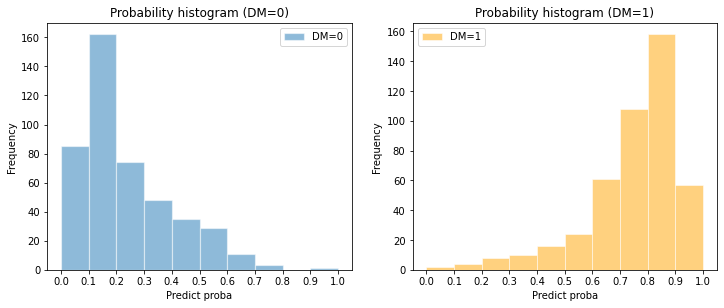

In [26]:
plot_proba_hist(proba_tr, train_y)

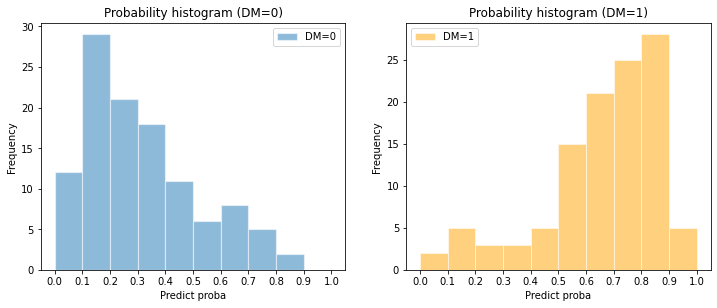

In [27]:
plot_proba_hist(proba_ts, test_y)

In [28]:
# plot_proba(proba_tr,train_y)

## result_ train

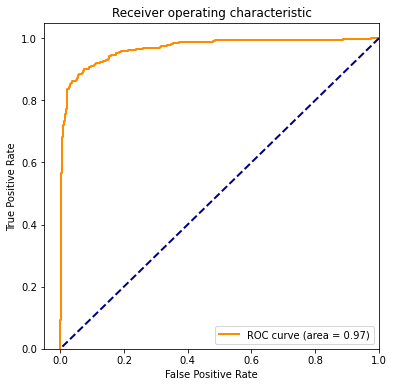

In [29]:
plot_roc_curve(proba_tr,train_y)

In [30]:
pred_tr = binary_converter(proba_tr, 0.5)
pred_ts = binary_converter(proba_ts, 0.5)

In [31]:
acc, sen, spe = round(bi_acc_sen_spe(pred_tr,train_y)[0],2), round(bi_acc_sen_spe(pred_tr,train_y)[1],2), round(bi_acc_sen_spe(pred_tr,train_y)[2],2)
print('acc',acc)
print('sen',sen)
print('spe',spe)

acc 0.91
sen 0.91
spe 0.9


In [32]:
confusion_matrix(train_y, pred_tr) # TN FP / FN TP

array([[404,  44],
       [ 40, 408]])

## result_test

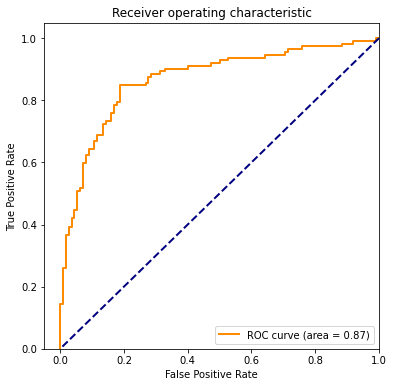

In [33]:
plot_roc_curve(proba_ts,test_y)

In [34]:
acc, sen, spe = round(bi_acc_sen_spe(pred_ts,test_y)[0],2), round(bi_acc_sen_spe(pred_ts,test_y)[1],2), round(bi_acc_sen_spe(pred_ts,test_y)[2],2)
print('acc',acc)
print('sen',sen)
print('spe',spe)

acc 0.83
sen 0.84
spe 0.81


In [35]:
confusion_matrix(test_y, pred_ts) # TN FP / FN TP

array([[91, 21],
       [18, 94]])

# _t-test_ about wrong prediction

In [98]:
# DM=0/1에 대해 각각 예측값이 0.5미만일때, 0.5이상일때의 index 
DM_0_predict_0=proba_ts.loc[test_y==0][proba_ts<=0.5] 
DM_0_predict_1=proba_ts.loc[test_y==0][proba_ts>0.5]
DM_1_predict_0=proba_ts.loc[test_y==1][proba_ts<=0.5]
DM_1_predict_1=proba_ts.loc[test_y==1][proba_ts>0.5]

In [99]:
print(DM_0_predict_0.shape+DM_0_predict_1.shape)
print(DM_1_predict_0.shape+DM_1_predict_1.shape)
DM_0_predict_1

(91, 21)
(18, 94)


2      0.577633
3      0.746693
11     0.640525
15     0.758328
17     0.558082
20     0.583066
25     0.847484
27     0.753464
37     0.619878
53     0.543994
60     0.652891
68     0.673170
75     0.632429
77     0.702194
79     0.626061
89     0.809801
94     0.606801
96     0.694792
98     0.546954
100    0.573066
107    0.738904
Name: 1, dtype: float64

In [100]:
# DM=0/1에 대해 각각 예측값이 0.5미만일때, 0.5이상일때 sample의 전체 데이터값 추출
DM_0_predict_0_data = train_x.loc[DM_0_predict_0.index,:]
DM_0_predict_1_data = train_x.loc[DM_0_predict_1.index,:]
DM_1_predict_0_data = train_x.loc[DM_1_predict_0.index,:]
DM_1_predict_1_data = train_x.loc[DM_1_predict_1.index,:]

In [101]:
# 각 범위간의 t-test 함수
from scipy import stats
statistic, p_value_0=stats.ttest_ind(DM_0_predict_0_data,DM_1_predict_0_data, equal_var=False)
t_value=pd.DataFrame(statistic)
t_value.index=[train_x.columns.tolist()]
t_value.sort_values(by=0)[0][0]
t_value.columns=["t-value"]
t_value

statistic, p_value_1=stats.ttest_ind(DM_0_predict_1_data,DM_1_predict_1_data, equal_var=False)
statistic, p_value_2=stats.ttest_ind(DM_0_predict_0_data,DM_0_predict_1_data, equal_var=False)
statistic, p_value_3=stats.ttest_ind(DM_1_predict_0_data,DM_1_predict_1_data, equal_var=False)
p_value_0=pd.DataFrame(p_value_0,columns=['pvalue'])
p_value_0.index=[train_x.columns.tolist()]
p_value_1=pd.DataFrame(p_value_1,columns=['pvalue'])
p_value_1.index=[train_x.columns.tolist()]
p_value_2=pd.DataFrame(p_value_2,columns=['pvalue'])
p_value_2.index=[train_x.columns.tolist()]
p_value_3=pd.DataFrame(p_value_3,columns=['pvalue'])
p_value_3.index=[train_x.columns.tolist()]

p_value.index=[train_x.columns.tolist()]
p_value_0 = round(p_value.sort_values(by=["pvalue"]).reset_index(drop=0),4)
#p_value.sort_values(by=0)[0][0]
#p_value.columns=["p-value"]
p_value


,level_0,pvalue
0,DRUGLP,0.0023
1,INS0,0.0421
2,WAIST,0.0452
3,HBA1C,0.0722
4,DRUGHT,0.0772
5,PLAT,0.1167
6,AGE,0.1180
7,HB,0.1671
8,SEX,0.1970
9,CREATININE,0.2737


## t-SNE 

In [43]:
from sklearn.manifold import TSNE

In [44]:
DM_0_predict_0_data['color']='red'
DM_0_predict_1_data['color']='orange'
DM_1_predict_0_data['color']='green'
DM_1_predict_1_data['color']='blue'

In [38]:
#g_train_x = train_x.copy() #train_x에 group정보 추가

#g_train_x.loc[DM_0_predict_0.index,"color"]='red'
#g_train_x.loc[DM_0_predict_1.index,"color"]='orange'
#g_train_x.loc[DM_1_predict_0.index,"color"]='green'
#g_train_x.loc[DM_1_predict_1.index,"color"]='blue'


In [45]:
#g_train_x['color']

In [55]:
# 데이터 
col_data=DM_0_predict_1_data.append(DM_1_predict_1_data)
data=col_data.drop(columns=['color'])

# color
color = col_data['color']
col_data

,AGE,WAIST,TOTALC,SMOKE,HBA1C,INS0,FMHTN,FMDM,GLU0,CREATININE,...,AST,ALT,WBC_B,PLAT,HB,SEX,BMI,SBP,DBP,color
2,71.0,95.4,0.00,2.0,6.4,12.2,1.0,1.0,117.0,1.10,...,23.0,22.0,7.9,131.0,14.4,1.0,27.1017,121.0,72.0,orange
4,66.0,93.0,45.33,1.0,6.0,8.8,1.0,1.0,121.0,1.20,...,20.0,21.0,4.4,230.0,15.4,1.0,26.5682,108.0,74.0,orange
7,51.0,81.9,37.62,2.0,5.6,6.4,1.0,1.0,103.0,1.20,...,38.0,17.0,4.7,361.0,15.6,1.0,22.3123,132.0,83.0,orange
21,66.0,98.7,79.56,2.0,6.1,12.0,1.0,1.0,108.0,1.08,...,34.0,27.0,4.8,221.0,14.6,1.0,25.1702,131.0,77.0,orange
32,71.0,97.3,0.00,1.0,6.1,7.6,1.0,1.0,97.0,0.79,...,21.0,30.0,4.0,208.0,11.8,2.0,27.5751,120.0,67.0,orange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,71.0,92.5,0.00,1.0,6.0,14.1,1.0,1.0,122.0,1.06,...,27.0,24.0,6.1,218.0,14.1,2.0,27.7308,143.0,90.0,blue
892,62.0,83.5,0.00,1.0,6.0,12.3,1.0,1.0,105.0,0.78,...,18.0,15.0,5.9,248.0,13.0,2.0,23.4876,122.0,79.0,blue
893,68.0,85.7,0.00,1.0,6.0,8.7,2.0,1.0,103.0,0.95,...,26.0,28.0,5.5,159.0,14.0,2.0,24.6826,133.0,88.0,blue
894,71.0,90.0,0.00,1.0,6.0,14.0,1.0,1.0,77.0,1.10,...,58.0,44.0,4.9,175.0,12.2,2.0,25.3384,142.0,66.0,blue


In [56]:
# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
model = TSNE(n_components=n_components)
transformed=model.fit_transform(data)

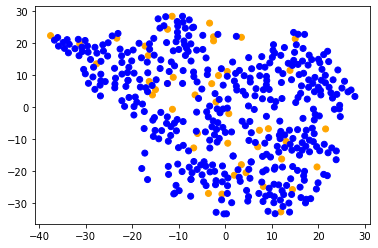

In [57]:
xs, ys=transformed[:,0], transformed[:,1]
#xs_2, ys_2=transformed_2[:,0], transformed_2[:,1]
#xs_3, ys_3=transformed_3[:,0], transformed_3[:,1]
#xs_4, ys_4=transformed_4[:,0], transformed_4[:,1]

# 학습한 결과 2차원 공간 값 출력

plt.scatter(xs, ys, c=color)  # DM 0 prediction 0
#plt.scatter(xs_2,ys_2, c='orange')  # DM 0 prediction 1
#plt.scatter(xs_3,ys_3, c='green')  # DM 1 prediction 0
#plt.scatter(xs_4,ys_4, c='blue')  # DM 1 prediction 1
plt.show()


In [ ]:
# 2차원으로 차원 축소
#n_components = 2

# t-sne 모델 생성
#model = TSNE(n_components=n_components)
#transformed=model.fit_transform(train_x)

#xs, ys=transformed[:,0], transformed[:,1]
#color = g_train_x['color']
#xs_2, ys_2=transformed_2[:,0], transformed_2[:,1]
#xs_3, ys_3=transformed_3[:,0], transformed_3[:,1]
#xs_4, ys_4=transformed_4[:,0], transformed_4[:,1]

# 학습한 결과 2차원 공간 값 출력

plt.scatter(xs, ys, c=color)  # DM 0 prediction 0
#plt.scatter(xs_2,ys_2, c='orange')  # DM 0 prediction 1
#plt.scatter(xs_3,ys_3, c='green')  # DM 1 prediction 0
#plt.scatter(xs_4,ys_4, c='blue')  # DM 1 prediction 1
plt.show()


# XGBoost

In [151]:
def xgb_fn(hp):
    hp_n_estimators = hp.Choice('n_estimators', [50,100, 200, 300, 400, 500])
    hp_max_depth = hp.Int('max_depth', 3,10,1)
#    hp_max_features = hp.Int('max_features', 3,10,1)
    
    model = XGBClassifier(n_estimators=hp_n_estimators, max_depth=hp_max_depth)#, 
                                      # max_features=hp_max_features, random_state=777)
    
    return model

In [152]:
# xgb = XGBClassifier()
# xgb = xgb.fit(train_x, train_y)

In [198]:
DIRECTORY='./MODEL/'
PROJECT_NAME='XGBoost_subsample'
COUNT=1
MAX_TRIALS=200

In [180]:
xgb_tuner = tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS,
        seed=777),
    hypermodel=xgb_fn,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    directory=DIRECTORY,
    project_name=PROJECT_NAME)

INFO:tensorflow:Reloading Oracle from existing project ./MODEL/XGBoost_norm/oracle.json
INFO:tensorflow:Reloading Tuner from ./MODEL/XGBoost_norm/tuner0.json


In [80]:
xgb_tuner.search(np.array(train_x), np.array(train_y))

INFO:tensorflow:Oracle triggered exit


In [222]:
best_xgb_hp = xgb_tuner.get_best_hyperparameters(num_trials=1)[0].values
best_xgb = xgb_tuner.get_best_models(num_models=1)[0]

In [223]:
best_xgb_hp_df = pd.DataFrame.from_dict([best_xgb_hp])
print(best_xgb_hp_df)

   n_estimators  max_depth
0           200          5


In [27]:
DIRECTORY+PROJECT_NAME+'/xgb_best_model.h5'

'./MODEL/XGBoost_2/xgb_best_model.h5'

In [126]:
joblib.dump(best_xgb, DIRECTORY+PROJECT_NAME+'/xgb_best_model.h5')
best_xgb_hp_df.to_csv(DIRECTORY+PROJECT_NAME+'/best_xgb_hp.csv', index=False)

## model loading

In [199]:
best_xgb = joblib.load(DIRECTORY+PROJECT_NAME+'/xgb_best_model.h5')
best_rf_hp_df= pd.read_csv(DIRECTORY+PROJECT_NAME+'/best_xgb_hp.csv')

In [200]:
best_rf_hp_df

,n_estimators,max_depth,subsample
0,400,9,0.8


In [201]:
best_xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 400,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

# evaluate 

In [202]:
proba_tr = best_xgb.predict_proba(train_x.values)
proba_tr = pd.DataFrame(proba_tr).iloc[:,1]

proba_ts = best_xgb.predict_proba(test_x.values)
proba_ts = pd.DataFrame(proba_ts).iloc[:,1]

In [203]:
train_x

,AGE,WAIST,TOTALC,SMOKE,HBA1C,INS0,FMHTN,FMDM,GLU0,CREATININE,...,TCHL,AST,ALT,WBC_B,PLAT,HB,SEX,BMI,SBP,DBP
0,79.0,83.6,0.00,1.0,5.5,6.8,1.0,1.0,84.0,0.86,...,190.0,22.0,10.0,4.0,322.0,12.2,2.0,21.9089,111.0,62.0
1,58.0,79.0,2.50,1.0,5.6,9.9,1.0,1.0,87.0,0.90,...,173.0,21.0,16.0,5.3,244.0,12.7,2.0,26.5161,138.0,80.0
2,71.0,95.4,0.00,2.0,6.4,12.2,1.0,1.0,117.0,1.10,...,142.0,23.0,22.0,7.9,131.0,14.4,1.0,27.1017,121.0,72.0
3,49.0,86.2,5.56,1.0,5.4,6.2,1.0,1.0,94.0,0.87,...,138.0,16.0,16.0,4.2,305.0,14.1,1.0,23.8365,110.0,66.0
4,66.0,93.0,45.33,1.0,6.0,8.8,1.0,1.0,121.0,1.20,...,171.0,20.0,21.0,4.4,230.0,15.4,1.0,26.5682,108.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,71.0,92.5,0.00,1.0,6.0,14.1,1.0,1.0,122.0,1.06,...,184.0,27.0,24.0,6.1,218.0,14.1,2.0,27.7308,143.0,90.0
892,62.0,83.5,0.00,1.0,6.0,12.3,1.0,1.0,105.0,0.78,...,155.0,18.0,15.0,5.9,248.0,13.0,2.0,23.4876,122.0,79.0
893,68.0,85.7,0.00,1.0,6.0,8.7,2.0,1.0,103.0,0.95,...,232.0,26.0,28.0,5.5,159.0,14.0,2.0,24.6826,133.0,88.0
894,71.0,90.0,0.00,1.0,6.0,14.0,1.0,1.0,77.0,1.10,...,164.0,58.0,44.0,4.9,175.0,12.2,2.0,25.3384,142.0,66.0


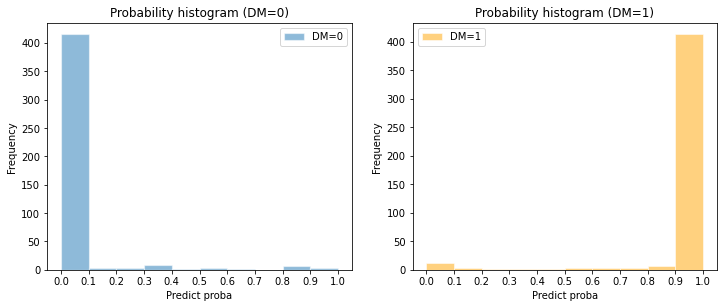

In [204]:
plot_proba_hist(proba_tr, train_y)

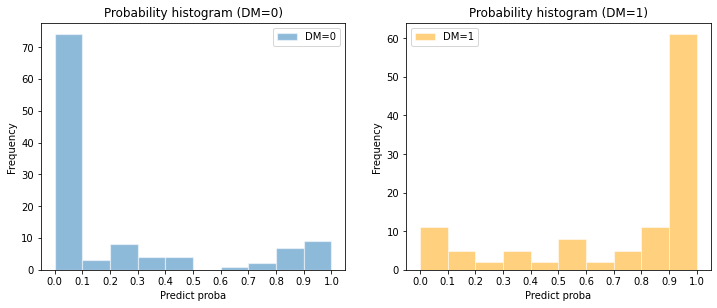

In [205]:
plot_proba_hist(proba_ts, test_y)

In [206]:
#plot_proba(proba_tr,train_y)

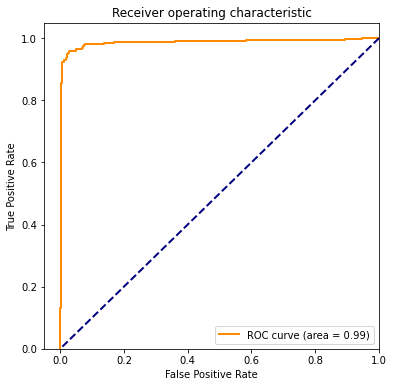

In [207]:
plot_roc_curve(proba_tr,train_y)

In [208]:
pred_tr = binary_converter(proba_tr, 0.5)
pred_ts = binary_converter(proba_ts, 0.5)

In [209]:
acc, sen, spe = round(bi_acc_sen_spe(pred_tr,train_y)[0],2), round(bi_acc_sen_spe(pred_tr,train_y)[1],2), round(bi_acc_sen_spe(pred_tr,train_y)[2],2)
print('acc',acc)
print('sen',sen)
print('spe',spe)

acc 0.96
sen 0.96
spe 0.97


In [210]:
confusion_matrix(train_y, pred_tr)

array([[433,  15],
       [ 19, 429]])

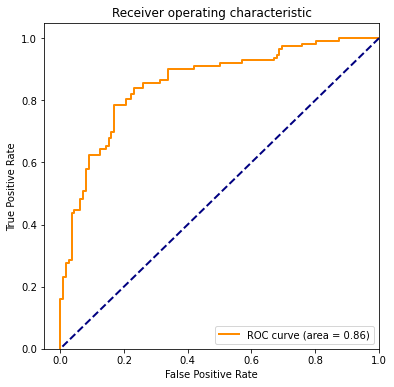

In [211]:
plot_roc_curve(proba_ts,test_y)

In [212]:
acc, sen, spe = round(bi_acc_sen_spe(pred_ts,test_y)[0],2), round(bi_acc_sen_spe(pred_ts,test_y)[1],2), round(bi_acc_sen_spe(pred_ts,test_y)[2],2)
print('acc',acc)
print('sen',sen)
print('spe',spe)

acc 0.8
sen 0.78
spe 0.83


In [213]:
confusion_matrix(test_y, pred_ts)

array([[93, 19],
       [25, 87]])